In [10]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import sys
sys.path.append('../../dstorch/')

import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [11]:
from dstorch import io, dataset, transforms, losses, models, predict, draw, utils
from dstorch.train import train
from dstorch.utils import variable
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm_notebook, tqdm
import numpy as np
import cv2
import skimage
from skimage import img_as_ubyte
import scipy.ndimage as nd

In [12]:
TRAIN_PATH = '../../kaggle-dsbowl-2018-dataset-fixes/stage1_train/'
TEST_PATH = '../../stage1_test/'

ids, images, masks = io.read_train_data(TRAIN_PATH, d=3)
test_ids, test_images = io.read_test_data(TEST_PATH, d=3)

Reading test data..: 100%|██████████| 65/65 [00:00<00:00, 268.83it/s]


In [4]:
classes = pd.read_csv("../../classes.csv")

images = utils.invert_images(classes, images, ids)
test_images = utils.invert_images(classes, test_images, test_ids)

In [5]:
rles = pd.read_csv("../../stage1_train_labels.csv")
labels = utils.rles2labels(rles, [x.shape for x in masks], ids)

100%|██████████| 664/664 [00:10<00:00, 64.21it/s]


In [6]:
def label2distance(label):
    distance = np.zeros_like(label, dtype=float)
    for i in np.unique(label):
        if i:
            instance = label == i
            dt = nd.distance_transform_edt(instance)
            dt /= dt.max()
            distance += dt
    return distance

def get_distances(labels):
    distances = []
    for label in tqdm(labels):
        distance = label2distance(label)
        distances.append(distance)
    return distances

In [7]:
distances = get_distances(labels)

100%|██████████| 664/664 [06:32<00:00,  1.69it/s]


In [80]:
centers = [d >= 0.6 for d in distances]
centers_04 = [d >= 0.4 for mask, d in zip(masks, distances)]

Границы значений: images [4, 44], masks [0.0, 1.0], labels [0, 22]


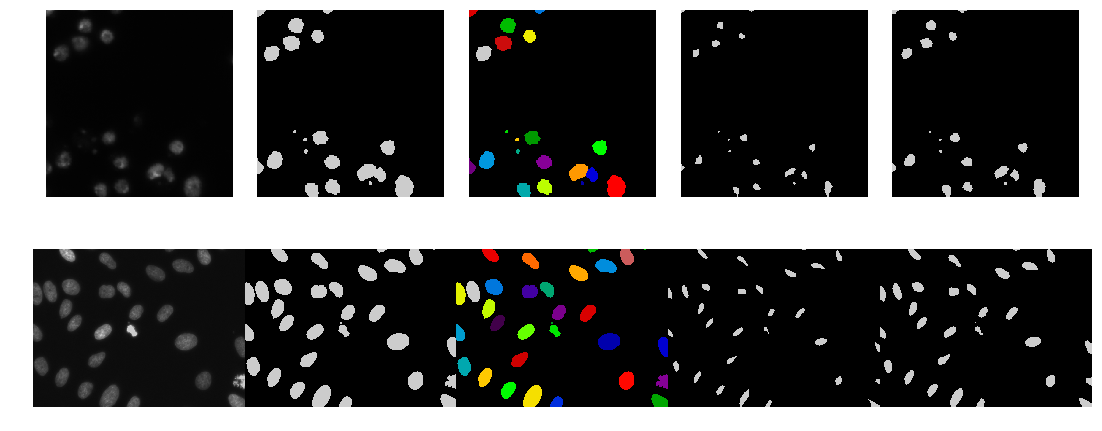

In [81]:
print('Границы значений: images [{}, {}], masks [{}, {}], labels [{}, {}]'.format(
    images[1].min(),
    images[1].max(),
    masks[1].min(),
    masks[1].max(),
    labels[1].min(),
    labels[1].max()
))


draw.plots([
    images[0], masks[0], labels[0], centers[0], centers_04[0],
    images[10], masks[10], labels[10], centers[10], centers_04[10]
], col_number=5, scale=3)

In [82]:
!rm -rf ../../data
!rm -rf ../../data/images 
!rm -rf ../../data/masks 
!rm -rf ../../data/test

In [83]:
!mkdir ../../data
!mkdir ../../data/images 
!mkdir ../../data/masks
!mkdir ../../data/test

In [84]:
answers = [np.stack([x, y, z], axis=-1) for x, y, z in zip(masks, centers, centers_04)]

In [85]:
for image, mask, _id in tqdm(zip(images, answers, ids), total=len(ids)):
    cv2.imwrite("../../data/images/{}.png".format(_id), image)
    cv2.imwrite("../../data/masks/{}.png".format(_id), mask)
    
for image, _id in tqdm(zip(test_images, test_ids), total=len(test_ids)):
    cv2.imwrite("../../data/test/{}.png".format(_id), image)

100%|██████████| 664/664 [00:03<00:00, 193.96it/s]


In [52]:
sub_test = pd.read_csv("../subs/2018-03-25 18:45:16.655058.csv")
sub_train = pd.read_csv("../../stage1_train_labels.csv")

In [53]:
def pixels_size(x):
    return sum([int(x) for x in x.split(' ')[1::2]])

sub_train['area'] = sub_train['EncodedPixels'].apply(pixels_size)
sub_test['area'] = sub_test['EncodedPixels'].apply(pixels_size)

In [54]:
train_area = sub_train.groupby('ImageId')['area'].median().reset_index()
test_area = sub_test.groupby('ImageId')['area'].median().reset_index()

In [55]:
train_shape = pd.DataFrame(
    [[_id, *img.shape[:2]] for _id, img in zip(ids, images)], 
    columns=['ImageId', 'height', 'width']
)

test_shape = pd.DataFrame(
    [[_id, *img.shape[:2]] for _id, img in zip(test_ids, test_images)], 
    columns=['ImageId', 'height', 'width']
)

In [56]:
train_scale = train_shape.merge(train_area, on='ImageId', how='left')
test_scale = test_shape.merge(test_area, on='ImageId', how='left')

In [113]:
train_scale['scale_height'] = (train_scale['height'] * np.sqrt(
    250 / train_scale['area'])).astype(int)
train_scale['scale_width'] = (train_scale['width'] * np.sqrt(
    250 / train_scale['area'])).astype(int)

In [114]:
test_scale['scale_height'] = (test_scale['height'] * np.sqrt(
    250 / test_scale['area'])).astype(int)
test_scale['scale_width'] = (test_scale['width'] * np.sqrt(
    250 / test_scale['area'])).astype(int)

In [115]:
train_scale.to_csv('train_scale.csv', index=False)
test_scale.to_csv('test_scale.csv', index=False)

In [116]:
train_scale = pd.read_csv('train_scale.csv')
test_scale = pd.read_csv('test_scale.csv')

In [117]:
images = []
answers = []
for _id in tqdm(ids):
    images.append(cv2.imread("../../data/images/{}.png".format(_id)))
    answers.append(cv2.imread("../../data/masks/{}.png".format(_id)))

100%|██████████| 664/664 [00:02<00:00, 273.38it/s]


In [118]:
test_images = []
for _id in tqdm(test_ids):
    test_images.append(cv2.imread("../../data/test/{}.png".format(_id)))

100%|██████████| 65/65 [00:00<00:00, 335.05it/s]


In [119]:
scaled_images = []
scaled_answers = []
scaled_test_images = []

for _id, img, answer in tqdm(zip(ids, images, answers), total=len(ids)):
    height = train_scale.loc[train_scale['ImageId'] == _id, 'scale_height'].iloc[0]
    width = train_scale.loc[train_scale['ImageId'] == _id, 'scale_width'].iloc[0]
    
    scaled_images.append(cv2.resize(img, (height, width)))
    scaled_answers.append(cv2.resize(answer, (height, width)))
    
for _id, img in tqdm(zip(test_ids, test_images), total=len(test_ids)):
    height = test_scale.loc[test_scale['ImageId'] == _id, 'scale_height'].iloc[0]
    width = test_scale.loc[test_scale['ImageId'] == _id, 'scale_width'].iloc[0]
    
    scaled_test_images.append(cv2.resize(img, (height, width)))

100%|██████████| 65/65 [00:00<00:00, 1076.09it/s]


In [120]:
!mkdir ../../data
!mkdir ../../data/scaled_images 
!mkdir ../../data/scaled_masks
!mkdir ../../data/scaled_test

mkdir: cannot create directory '../../data': File exists
mkdir: cannot create directory '../../data/scaled_images': File exists
mkdir: cannot create directory '../../data/scaled_masks': File exists
mkdir: cannot create directory '../../data/scaled_test': File exists


In [121]:
for image, mask, _id in tqdm(zip(scaled_images, scaled_answers, ids), total=len(ids)):
    cv2.imwrite("../../data/scaled_images/{}.png".format(_id), image)
    cv2.imwrite("../../data/scaled_masks/{}.png".format(_id), mask)
    
for image, _id in tqdm(zip(scaled_test_images, test_ids), total=len(test_ids)):
    cv2.imwrite("../../data/scaled_test/{}.png".format(_id), image)

100%|██████████| 65/65 [00:00<00:00, 314.67it/s]


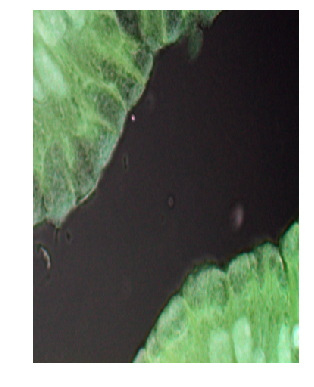

In [124]:
draw.plots([scaled_test_images[0]])

In [122]:
train_scale['scale_width'].sort_values()

294      95
480      98
322     110
332     111
568     114
262     116
368     121
547     122
157     123
274     123
72      124
318     124
246     125
50      126
267     126
233     127
352     127
257     127
169     127
645     128
297     128
38      128
190     128
353     129
440     129
584     129
8       130
100     130
194     130
241     130
       ... 
402     529
607     555
35      563
199     578
625     580
383     598
17      603
195     648
400     884
369     896
489     898
31      924
58      950
559    1011
141    1020
630    1033
659    1086
561    1095
205    1151
474    1162
551    1176
596    1244
324    1516
549    1523
227    1782
280    1793
278    1806
177    1879
483    1913
455    2277
Name: scale_width, Length: 664, dtype: int64

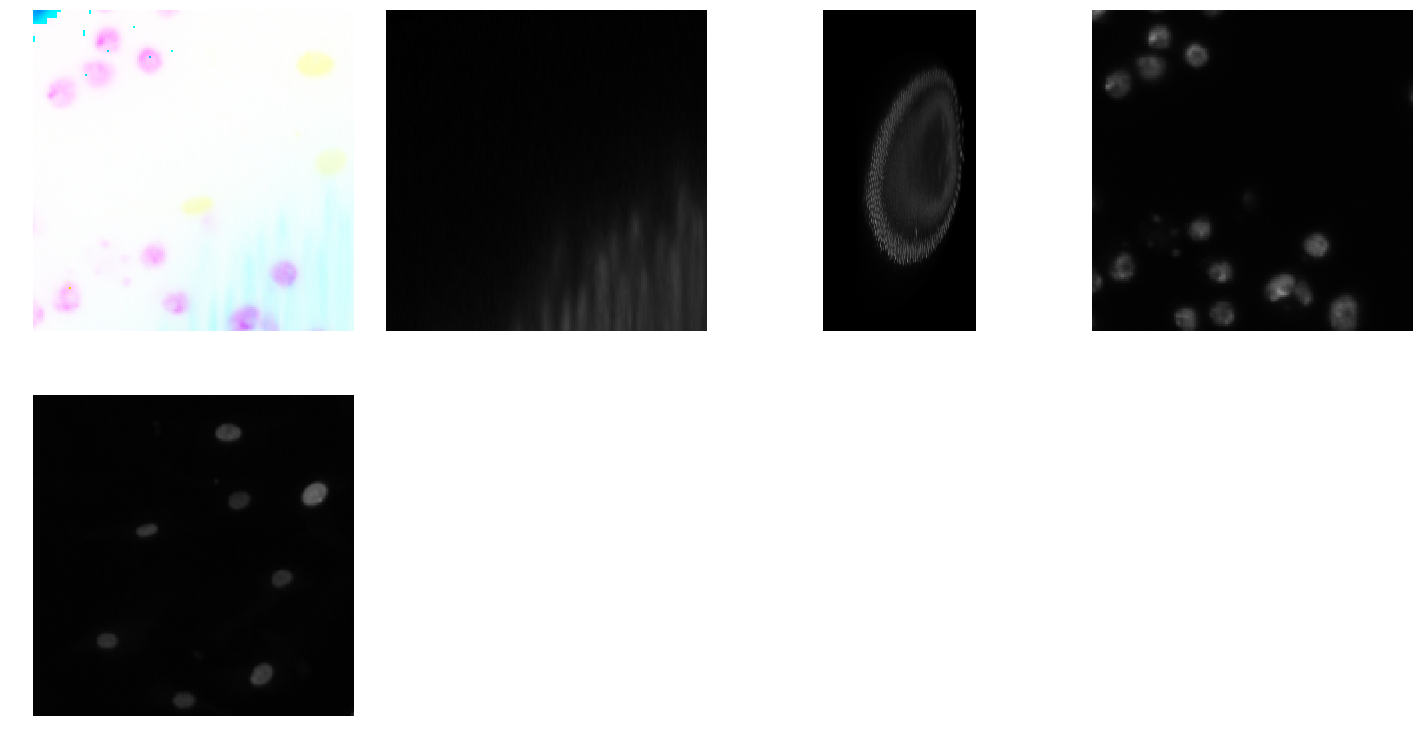

In [105]:
new = np.zeros((160, 160, 3))
new[..., 0] = scaled_images[455][250:410, 400:560][..., 0]
new[..., 1] = scaled_images[0][:160, :160][..., 1]
new[..., 2] = scaled_test_images[30][:160, :160][..., 2]
draw.plots([new, scaled_images[455][250:410, 400:560], scaled_images[455], scaled_images[0], scaled_test_images[30]])

In [39]:
scaled_images[19].shape

(362, 362, 3)

In [71]:
scaled_images[486].shape

(657, 492, 3)

In [72]:
images[486].shape

(1040, 1388, 3)